# 603_ Project : YOU TUBE VIDEO TREND ANALYSIS

## Objective:
   Analyze the patterns that make a youtube video trend utilizing big data tools and provide insights to creators

## Dataset : 
   Kaggle(CSV) : https://www.kaggle.com/datasets/canerkonuk/youtube-trending-videos-global?resource=download

   

In [1]:
import os
import findspark

# Setting environment variables
os.environ["JAVA_HOME"] = r"C:\Java\jdk-1.8"
os.environ["SPARK_HOME"] = r"C:\Spark\spark-3.4.4-bin-hadoop3"
os.environ["HADOOP_HOME"] = r"C:\DRS_Hadoop\Hadoop"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["SPARK_HOME"], "bin")
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["HADOOP_HOME"], "bin") 

In [3]:
# Initializing Spark
findspark.init() 

## Creating a Spark Session

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .appName("Youtube_Video_Trend_Analysis")\
    .master("local[2]")\
    .config("spark.driver.memory", "2g")\
    .getOrCreate() 

In [7]:
spark.sparkContext.setLogLevel("ERROR") 

In [9]:
spark.version 

'3.4.4'

In [11]:
spark.range(5).show() 

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



## Reading the dataset from local HDFS

In [13]:
df = spark.read.option("header", True) \
               .option("inferSchema", True) \
               .option("multiLine", True) \
               .option("escape", '\"') \
               .csv("hdfs://localhost:9000/603_project/603_project/youtube_trending_videos_global.csv") 

## Looking at the Schema(Columns in the dataset)

In [15]:
df.printSchema() 

root
 |-- video_id: string (nullable = true)
 |-- video_published_at: string (nullable = true)
 |-- video_trending__date: string (nullable = true)
 |-- video_trending_country: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- video_title: string (nullable = true)
 |-- video_description: string (nullable = true)
 |-- video_default_thumbnail: string (nullable = true)
 |-- video_category_id: string (nullable = true)
 |-- video_tags: string (nullable = true)
 |-- video_duration: string (nullable = true)
 |-- video_dimension: double (nullable = true)
 |-- video_definition: string (nullable = true)
 |-- video_licensed_content: boolean (nullable = true)
 |-- video_view_count: double (nullable = true)
 |-- video_like_count: double (nullable = true)
 |-- video_comment_count: double (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- channel_description: string (nullable = true)
 |-- channel_custom_url: string (nullable = true)
 |-- channel_published_at: tim

## Displaying the first 5 rows of the dataset

In [17]:
df.show(5) 

+-----------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+-----------------------+-----------------+----------------------+--------------+---------------+----------------+----------------------+----------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+------------------------+-------------------------------+-------------------+-----------------------+-----------------------------+
|   video_id|  video_published_at|video_trending__date|video_trending_country|          channel_id|         video_title|   video_description|video_default_thumbnail|video_category_id|            video_tags|video_duration|video_dimension|video_definition|video_licensed_content|video_view_count|video_like_count|video_comment_count|       channel_title| channel_description|  channel_custom_url|channel_published_at|cha

## Retrieving only required columns for more clarity

In [19]:
#To avoid clumsiness retrieving only required columns
df.select(
    "video_id", 
    "video_published_at",
    "video_title", 
    "video_trending_country", 
    "video_view_count", 
    "video_like_count", 
    "video_comment_count"
).show(10, truncate=True) 

+-----------+--------------------+--------------------+----------------------+----------------+----------------+-------------------+
|   video_id|  video_published_at|         video_title|video_trending_country|video_view_count|video_like_count|video_comment_count|
+-----------+--------------------+--------------------+----------------------+----------------+----------------+-------------------+
|bB3-CUMERIU|2024-10-11T00:00:06Z|JENNIE - Mantra (...|  United Arab Emirates|     2.0535235E7|       2042255.0|           152933.0|
|5ObJt_71AYc|2024-10-11T02:59:21Z|CHILE vs. BRASIL ...|  United Arab Emirates|       3966042.0|            null|             2549.0|
|zfb0whgBBA8|2024-10-11T11:07:25Z|تحدي الحقيبة مع ا...|  United Arab Emirates|        853167.0|        101155.0|            10541.0|
|SJfoPdeOPCQ|2024-10-11T00:10:10Z|VENEZUELA vs. ARG...|  United Arab Emirates|       3758707.0|            null|             3115.0|
|UVb6QOKy0bI|2024-10-09T12:30:27Z|Bougainvillea Tra...|  United Arab 

In [21]:
df.select(
    "video_tags",
    "video_description",
    "video_category_id",
    "video_trending__date"
).show(10, truncate=True) 

+----------------------+--------------------+-----------------+--------------------+
|            video_tags|   video_description|video_category_id|video_trending__date|
+----------------------+--------------------+-----------------+--------------------+
|JENNIE,Mantra,제니,...|Official music vi...|            Music|          2024.10.12|
|  fútbol,pelota,gol...|#Chile #Brasil #e...|           Sports|          2024.10.12|
|  تشكيله,فيفا,فيفا2...|1,375,547 مشترك❤️...|           Gaming|          2024.10.12|
|  fútbol,pelota,gol...|#Venezuela #Argen...|           Sports|          2024.10.12|
|                  null|Presenting The Of...| Film & Animation|          2024.10.12|
|  #FreeFire #FreeFi...|هل انت جاهز للتحد...|           Gaming|          2024.10.12|
|  tseries,tseries s...|Haveli Ka Darwaza...|            Music|          2024.10.12|
|                  null|#تصفيات_أمريكا_ال...|           Sports|          2024.10.12|
|  اسراء,اسراء نبيل,...|عملت مقلب في أخو...|   People & Blogs|    

## Counting number of rows before and after cleaning the data

In [23]:
df.count() 

2814627

In [25]:
# Dropping the rows where views, likes, comments are missing
important_cols = ["video_view_count", "video_like_count", "video_comment_count"]
df_cleaned = df.na.drop(subset=important_cols)

# Checking the row count after cleaning
print("Row count after cleaning the dataset:", df_cleaned.count()) 

Row count after cleaning the dataset: 2765094


### Casting metrics to long for numeric operations

In [27]:
# Casting to correct types
from pyspark.sql.functions import col
df_cleaned = df_cleaned.withColumn("video_view_count", col("video_view_count").cast("long")) \
                       .withColumn("video_like_count", col("video_like_count").cast("long")) \
                       .withColumn("video_comment_count", col("video_comment_count").cast("long")) 

In [29]:
from pyspark.sql.functions import to_timestamp

df_cleaned = df_cleaned.withColumn("video_published_at", to_timestamp(col("video_published_at"))) 

### Filtering the duplicate values

In [31]:
 df_cleaned = df_cleaned.filter((col("video_view_count") > 0) &
                               (col("video_like_count") >= 0) &
                               (col("video_comment_count") >= 0)) \
                       .dropDuplicates() 

## Feature Engineering
  1. Adding new columns :
     1. title_length: gives the number of characters in a title
     2. descrip_length: gives the number of characters in description
     3. tags_count: gives number of tags in a video
     4. has_description: returns 1 if the video has a description, otherwise 0
     5. has_tags: returns 1 if the video has at-least one tag, otherwise 0
     6. title_word_count: counts how many words are present in the video title
     7. video_published_at_ts: converts video_published_at from string format to a timestamp format
     8. hour_of_publish: extracts the hour (0–23) from the video’s publish timestamp 
     9. day_of_week: extracts the weekday (1 = Sunday, 7 = Saturday) from the publish timestamp
     10. like_to_view_ratio: calculates the ratio of the number of likes to the number of total views
     11. comment_to_view_ratio: calculates the ratio of number of comments to total number of views

In [33]:
from pyspark.sql.functions import length, split, size, when,hour, dayofweek, to_timestamp, avg

df_engineered = df_cleaned \
    .withColumn("title_length", length(col("video_title"))) \
    .withColumn("descrip_length", length(col("video_description"))) \
    .withColumn("tags_count", size(split(col("video_tags"), ","))) \
    .withColumn("has_description", when(length(col("video_description")) > 0, 1).otherwise(0)) \
    .withColumn("has_tags", when(length(col("video_tags")) > 0, 1).otherwise(0)) \
    .withColumn("title_word_count", size(split(col("video_title"), " "))) \
    .withColumn("video_published_at_ts", to_timestamp(col("video_published_at"))) \
    .withColumn("hour_of_publish", hour(col("video_published_at_ts"))) \
    .withColumn("day_of_week", dayofweek(col("video_published_at_ts"))) \
    .withColumn("like_to_view_ratio", (col("video_like_count") / col("video_view_count"))) \
    .withColumn("comment_to_view_ratio", (col("video_comment_count") / col("video_view_count"))) 

### Showing the feature engineered variables

In [35]:
df_engineered.select(
    "video_title", "video_view_count", "video_like_count",
    "title_length", "tags_count", "hour_of_publish", "like_to_view_ratio"
).show(5, truncate=True) 

+--------------------+----------------+----------------+------------+----------+---------------+--------------------+
|         video_title|video_view_count|video_like_count|title_length|tags_count|hour_of_publish|  like_to_view_ratio|
+--------------------+----------------+----------------+------------+----------+---------------+--------------------+
|JENNIE - Mantra (...|         6747612|          492232|          36|         3|              3| 0.07294906701807988|
|Naiara, Natos - V...|          305895|           11220|          38|        20|             18| 0.03667925268474476|
|Black Sherif, Fir...|          242288|           15754|          55|         4|             13| 0.06502179224724296|
|Black Sherif, Fir...|         1560472|           51995|          60|         4|             19| 0.03332004675508436|
|Black Sherif, Fir...|         2821848|           37845|          55|         4|             13|0.013411424002993782|
+--------------------+----------------+----------------+

### Understanding the statistics

In [37]:
df_cleaned.select("video_view_count", "video_like_count", "video_comment_count").summary().show() 

+-------+--------------------+-----------------+-------------------+
|summary|    video_view_count| video_like_count|video_comment_count|
+-------+--------------------+-----------------+-------------------+
|  count|             2765093|          2765093|            2765093|
|   mean|1.4305166233725954E7|425396.0335681295|  7480.815574015051|
| stddev|    3.006686734635E7|919815.9754449163|  24316.38386671933|
|    min|                5715|                0|                  0|
|    25%|              711419|            21637|                579|
|    50%|             2421136|            79154|               1729|
|    75%|            12748118|           372720|               4742|
|    max|           407522999|         10904239|             600991|
+-------+--------------------+-----------------+-------------------+



# Average Engagement category-wise 

### Removing rows where video_category_id is null

In [39]:
df_engineered = df_engineered.filter(col("video_category_id").isNotNull()) 

### Diplaying all the video categories 

In [41]:
df_engineered.select("video_category_id").distinct().show(50, truncate=False) 

+---------------------+
|video_category_id    |
+---------------------+
|Education            |
|Gaming               |
|Entertainment        |
|Travel & Events      |
|Science & Technology |
|Sports               |
|Howto & Style        |
|Nonprofits & Activism|
|Film & Animation     |
|People & Blogs       |
|News & Politics      |
|Pets & Animals       |
|Autos & Vehicles     |
|Music                |
|Comedy               |
+---------------------+



In [43]:
#Aggregating to get the avg views, likes and comments based on video category 
from pyspark.sql.functions import avg
df_engineered.groupBy("video_category_id").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments")
).orderBy("avg_views", ascending=False).show() 

+--------------------+--------------------+------------------+------------------+
|   video_category_id|           avg_views|         avg_likes|      avg_comments|
+--------------------+--------------------+------------------+------------------+
|      Pets & Animals|3.1643681276866823E7| 735531.8112894932| 2613.255670456493|
|       Howto & Style|2.7609591151734866E7|471960.12368390604|2137.7825343566406|
|Science & Technology|2.3367265425655592E7| 908480.4002735474| 4675.148767721403|
|      People & Blogs|1.9629372802493434E7|492867.63251430274| 5013.073104298787|
|       Entertainment| 1.788961632813594E7|  571486.179893586|  6066.44212603598|
|     Travel & Events|1.7458120911746904E7| 672139.7462998624|3791.2861072902338|
|              Comedy|1.6057439157992577E7|  481968.579359719|3222.2785743231507|
|              Sports|1.1669750975318411E7|368611.81310576655| 6134.004908513437|
|               Music|   8806585.352053937| 304880.2275828271|17525.820441841508|
|    Film & Anim

In [45]:
df_category_engagement = df_engineered.groupBy("video_category_id").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments")
).orderBy("avg_views", ascending=False) 

In [47]:
# converting to pandas for plotting
df_category_pd = df_category_engagement.toPandas() 

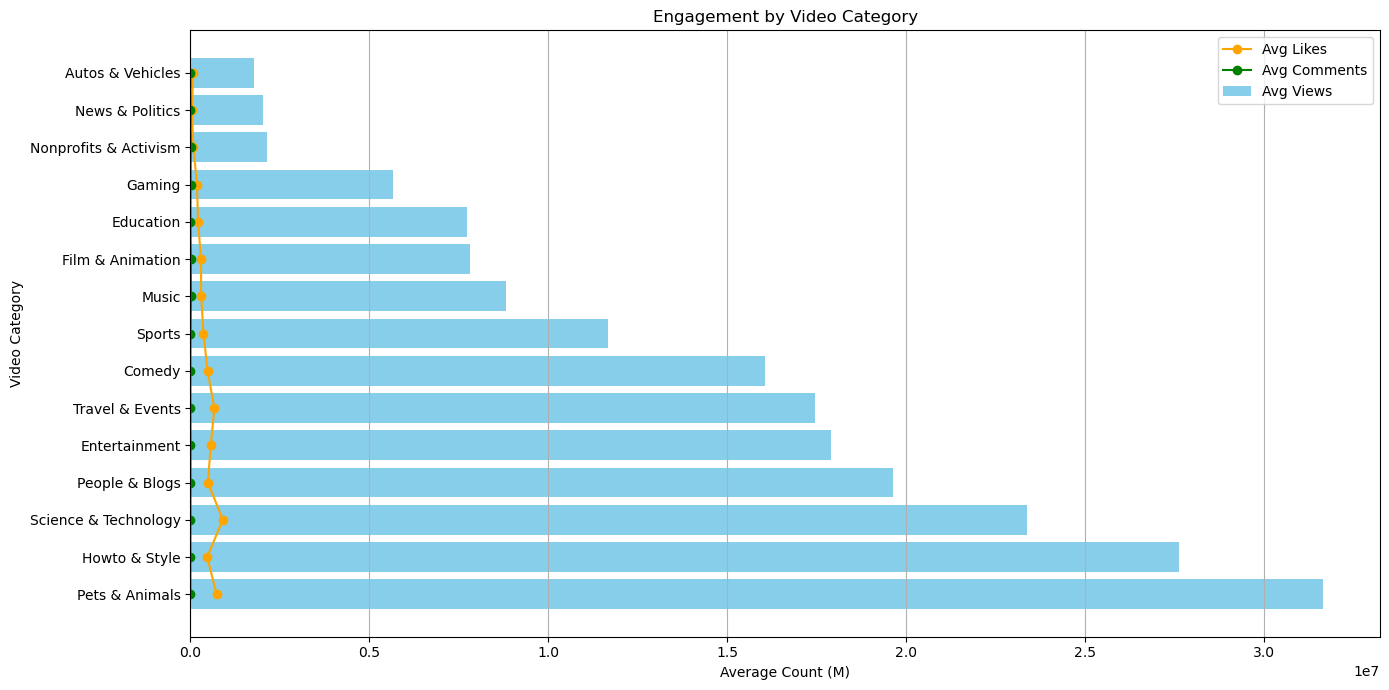

In [49]:
#plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.barh(df_category_pd["video_category_id"], df_category_pd["avg_views"], color="skyblue", label="Avg Views")
plt.plot(df_category_pd["avg_likes"], df_category_pd["video_category_id"], marker='o', color="orange", label="Avg Likes")
plt.plot(df_category_pd["avg_comments"], df_category_pd["video_category_id"], marker='o', color="green", label="Avg Comments")

plt.xlabel("Average Count (M)")
plt.ylabel("Video Category")
plt.title("Engagement by Video Category")
plt.legend()
plt.grid(axis="x")
plt.tight_layout()
plt.show() 

    1.From the plot it can be seen that categories like pet & animals, howto & style and science and technology had higher views
    2.Auto & vehicles, News & poltics and nonprofits and activism had lower values 

## Engagement by country globally

In [51]:
# aggregating to get avg views, likes and comments based on countries 
from pyspark.sql.functions import avg
df_engineered.groupBy("video_trending_country").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments")
).orderBy("avg_views", ascending=False).show(10, truncate=False) 

+----------------------+--------------------+------------------+------------------+
|video_trending_country|avg_views           |avg_likes         |avg_comments      |
+----------------------+--------------------+------------------+------------------+
|Bangladesh            |4.641839303851212E7 |1051571.807063686 |3248.2289122675184|
|Malaysia              |4.226406408231424E7 |1191551.3024386754|6237.398841450333 |
|El Salvador           |3.9816988333593935E7|1183499.7246812605|6145.692987731537 |
|Uganda                |3.9469139342022836E7|996626.5939173487 |4131.233404061837 |
|Nepal                 |3.705445314630504E7 |984092.9648724536 |3333.0845928669573|
|Pakistan              |3.54035585278465E7  |908061.7418089664 |3664.6606528691245|
|South Africa          |3.5325085126985155E7|1075530.5429309232|5698.686959328599 |
|Portugal              |3.52995554357281E7  |1064486.2241344806|7178.497365085718 |
|Zimbabwe              |3.4772310337461784E7|1081998.0511875832|8753.8654072

In [53]:
# Aggregating for handling with pandas to plot
df_country_engagement = df_engineered.groupBy("video_trending_country").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments")
).orderBy("avg_views", ascending=False) 

In [55]:
# converting to pandas for plotting
df_country_pd = df_country_engagement.toPandas() 

In [57]:
#Keeping only top 15 countries to avoid clutter
df_country_pd_top = df_country_pd.head(15) 

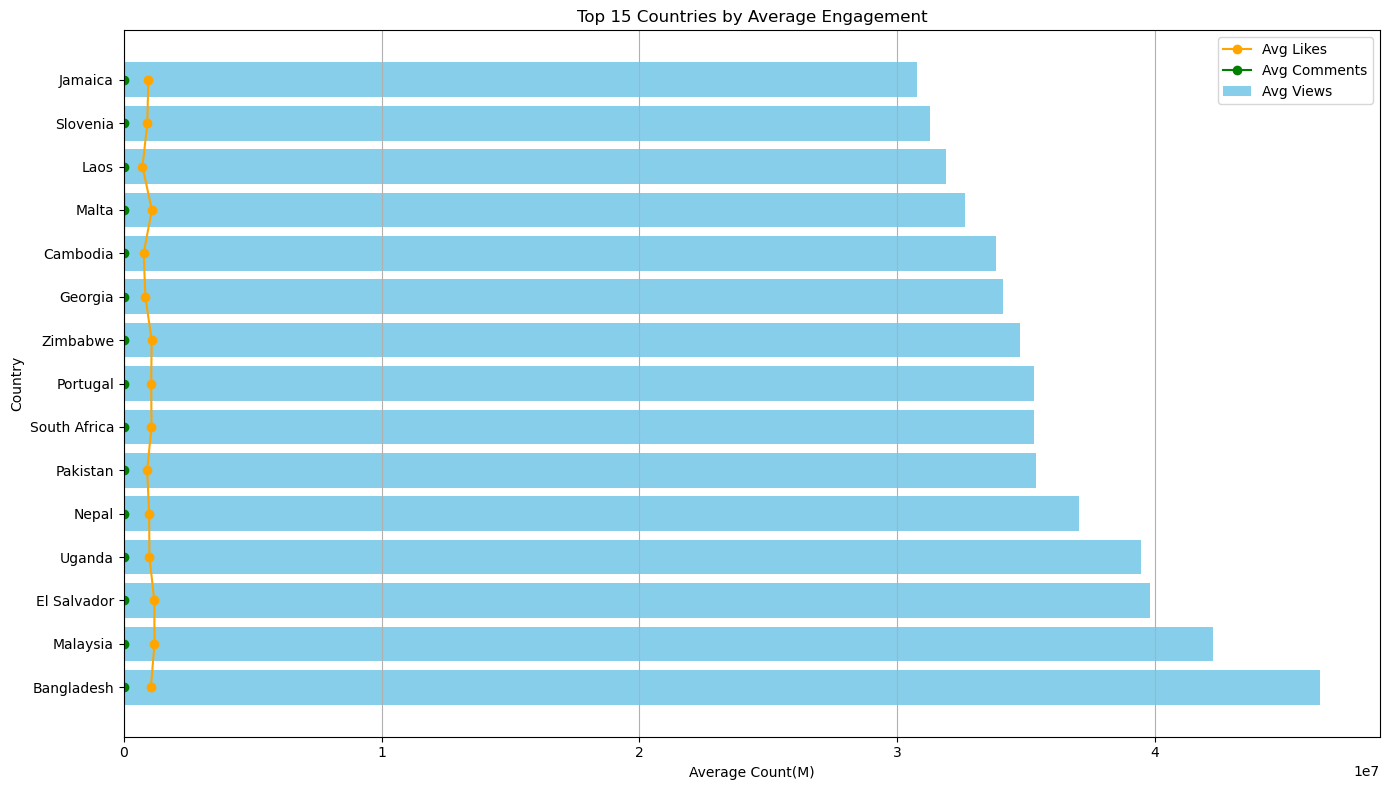

In [59]:
#Plotting 
plt.figure(figsize=(14, 8))
plt.barh(df_country_pd_top["video_trending_country"], df_country_pd_top["avg_views"], label="Avg Views", color="skyblue")
plt.plot(df_country_pd_top["avg_likes"], df_country_pd_top["video_trending_country"], marker='o', color="orange", label="Avg Likes")
plt.plot(df_country_pd_top["avg_comments"], df_country_pd_top["video_trending_country"], marker='o', color="green", label="Avg Comments")

plt.title("Top 15 Countries by Average Engagement")
plt.xlabel("Average Count(M)")
plt.ylabel("Country")
plt.legend()
plt.grid(axis="x")
plt.tight_layout()
plt.show() 

Globally countries like Bangladesh, Malaysia, El salvador and Uganda had higher avg views while compared to other countries

## Engagement by time of publishing

In [61]:
#aggregating to get the avg views, likes and comments based on the time of publishing a video
df_engineered.groupBy("hour_of_publish").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments")
).orderBy("hour_of_publish").show(24) 

+---------------+--------------------+------------------+------------------+
|hour_of_publish|           avg_views|         avg_likes|      avg_comments|
+---------------+--------------------+------------------+------------------+
|              0|2.1614138067330297E7| 769101.8331129396|40749.643109021454|
|              1|1.6562831808535568E7| 356720.0699666701| 2336.045464014165|
|              2|2.2851320992588952E7| 526550.7881933064|2458.2169416220545|
|              3|1.8079290474453043E7|   490032.58047727| 5569.419925149901|
|              4| 1.833822730642489E7| 431889.7417921002|  5732.41371855743|
|              5| 1.307504498326363E7| 315301.8931135108| 3942.282715895259|
|              6|1.2651705284356577E7|297922.07073639485|3617.2479463496516|
|              7| 1.748071753616411E7| 440254.3629251512|3173.2457970371192|
|              8|1.5021501209732156E7| 470520.2356929861|6218.2705996426985|
|              9|1.7160388735090565E7| 456303.2028613703| 5677.309971839725|

In [63]:
df_hour_engagement = df_engineered.groupBy("hour_of_publish").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments")
).orderBy("hour_of_publish")  

In [65]:
# converting to pandas for plotting
df_hour_pd = df_hour_engagement.toPandas() 

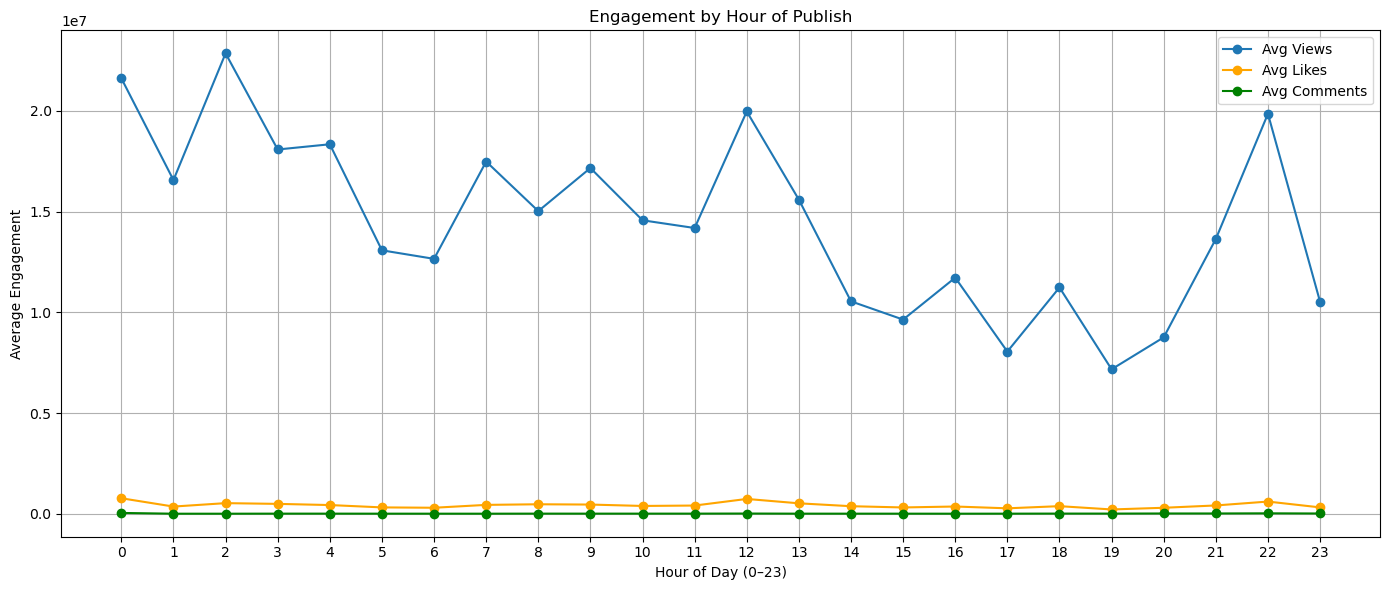

In [67]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_hour_pd["hour_of_publish"], df_hour_pd["avg_views"], marker='o', label="Avg Views")
plt.plot(df_hour_pd["hour_of_publish"], df_hour_pd["avg_likes"], marker='o', color="orange", label="Avg Likes")
plt.plot(df_hour_pd["hour_of_publish"], df_hour_pd["avg_comments"], marker='o', color="green", label="Avg Comments")

plt.title("Engagement by Hour of Publish")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Engagement")
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show() 

Best publishing hours are:

Hour 0-22-23 PM: High views

Hours 1–3 AM: High views

Hour  2-8 PM: Lowest views

## Does title length impact video to trend

In [69]:
from pyspark.sql.functions import floor

# Creating buckets of title lengths (e.g., 0–10, 10–20,...)
df_buckets = df_engineered.withColumn("title_len_bucket", floor(col("title_length") / 10) * 10)

df_buckets.groupBy("title_len_bucket").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments") 
).orderBy("title_len_bucket").show() 

+----------------+--------------------+------------------+------------------+
|title_len_bucket|           avg_views|         avg_likes|      avg_comments|
+----------------+--------------------+------------------+------------------+
|               0| 2.903920241248304E7| 536304.2264004652| 4332.677941461524|
|              10| 2.400533157633665E7| 703708.7762989678| 5830.838047881145|
|              20| 2.288923790956143E7| 750517.9728214012| 7633.266815676884|
|              30|1.7039350346554667E7| 590833.7687339636| 10467.15724919757|
|              40|1.1649320765698176E7| 346362.0229111367|10278.264077214399|
|              50|   8826519.539994463|247589.75763942898| 6690.123488393551|
|              60|   7478566.671511223|210212.60983736312|  6617.85023085766|
|              70|      9660539.630488| 228663.1119814229|3516.8411527069775|
|              80|1.3584718225216372E7|  295414.905189741| 4345.834777922201|
|              90| 1.536394650405619E7| 352711.6627185076| 4135.

In [71]:
#Aggregate engagement by bucket
df_title_engagement = df_buckets.groupBy("title_len_bucket").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments")
).orderBy("title_len_bucket") 

In [73]:
# converting to pandas for plotting
df_title_pd = df_title_engagement.toPandas() 

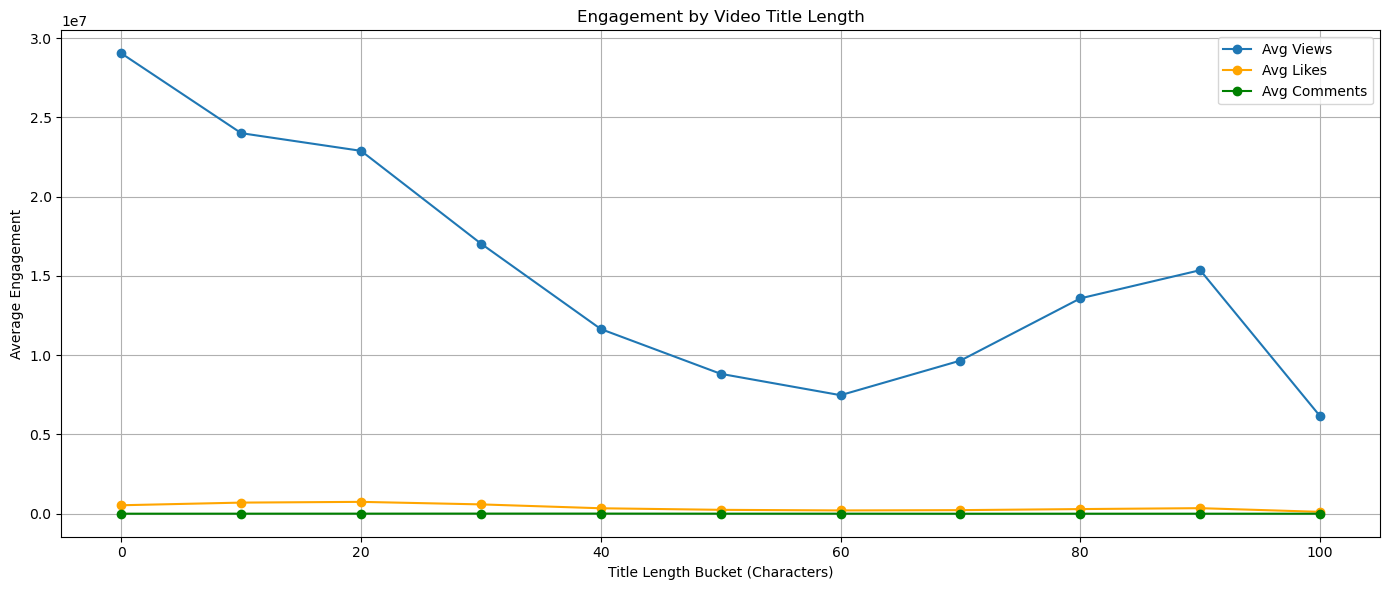

In [75]:
#Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_title_pd["title_len_bucket"], df_title_pd["avg_views"], marker='o', label="Avg Views")
plt.plot(df_title_pd["title_len_bucket"], df_title_pd["avg_likes"], marker='o', color="orange", label="Avg Likes")
plt.plot(df_title_pd["title_len_bucket"], df_title_pd["avg_comments"], marker='o', color="green", label="Avg Comments")

plt.title("Engagement by Video Title Length")
plt.xlabel("Title Length Bucket (Characters)")
plt.ylabel("Average Engagement")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show() 

title_len_bucket	What It Means	Insights

0–10	Very short titles	Highest average views 

10–30	Moderately short	Good balance of views 

40–60	Mid-length	Sharp drop in engagement 

70–100+	Long titles	Low views, few comments 

# What days of a week did the video had highest average views, likes and comments? 

In [77]:
from pyspark.sql.functions import avg
#Aggregation
df_day_views = df_engineered.groupBy("day_of_week").agg(
    avg("video_view_count").alias("avg_views"),
    avg("video_like_count").alias("avg_likes"),
    avg("video_comment_count").alias("avg_comments")
).orderBy("day_of_week")

# Showing  the results
df_day_views.show(7) 

+-----------+--------------------+------------------+------------------+
|day_of_week|           avg_views|         avg_likes|      avg_comments|
+-----------+--------------------+------------------+------------------+
|          1| 1.327206086724999E7|375933.98172631854| 6045.680295586504|
|          2|  1.40159939603438E7| 407877.4935639746| 5318.660155656574|
|          3| 1.400906334687178E7|396722.49535059405| 5050.530666849804|
|          4|1.3056258914124178E7|396941.36497224733| 5090.817263456822|
|          5| 1.361669047786344E7| 408233.8202705543| 8564.549282688287|
|          6|1.5477410985602701E7|490467.25795219885|13202.543775291928|
|          7| 1.667379308382758E7|495166.11725235375| 7903.806437193811|
+-----------+--------------------+------------------+------------------+



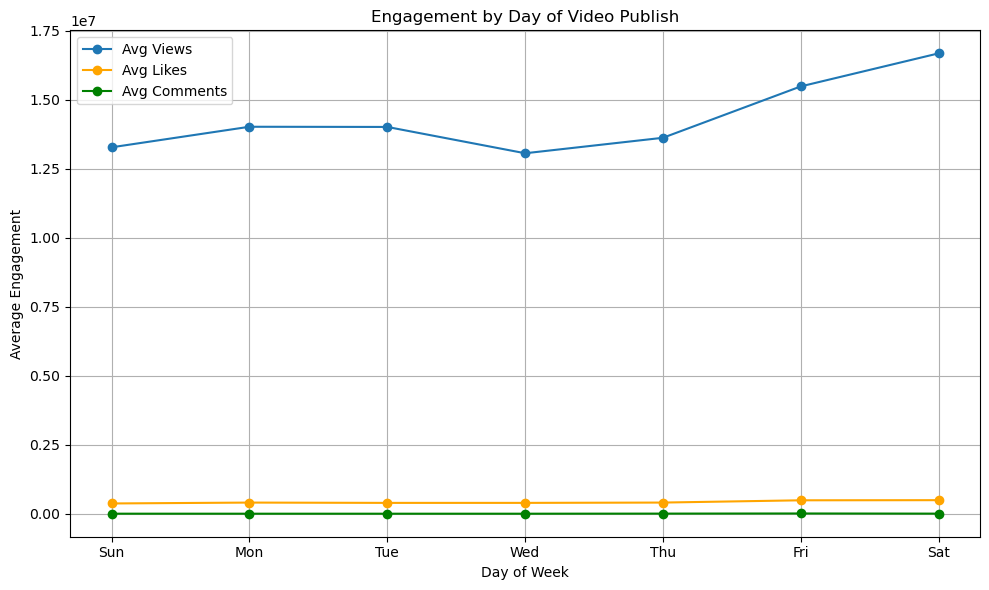

In [79]:
# converting to pandas for plotting
df_day_pd = df_day_views.toPandas()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_day_pd["day_of_week"], df_day_pd["avg_views"], marker='o', label="Avg Views")
plt.plot(df_day_pd["day_of_week"], df_day_pd["avg_likes"], marker='o', label="Avg Likes", color="orange")
plt.plot(df_day_pd["day_of_week"], df_day_pd["avg_comments"], marker='o', label="Avg Comments", color="green")
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7], labels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel("Day of Week")
plt.ylabel("Average Engagement")
plt.title("Engagement by Day of Video Publish")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show() 

It can be seen that on Fridays and Saturdays are the best time to publish a video

# Analysis by individual Country

### Total number of countries 

In [81]:
df_engineered.select("video_trending_country").distinct().count() 

110

### Country names(50)

In [83]:
df_engineered.select("video_trending_country").distinct().show(50, truncate=False) 

+----------------------+
|video_trending_country|
+----------------------+
|Paraguay              |
|Russia                |
|Yemen                 |
|Senegal               |
|Sweden                |
|Philippines           |
|Singapore             |
|Malaysia              |
|Turkey                |
|Iraq                  |
|Germany               |
|Cambodia              |
|Jordan                |
|France                |
|Greece                |
|Sri Lanka             |
|Taiwan                |
|Algeria               |
|Slovakia              |
|Argentina             |
|Belgium               |
|Qatar                 |
|Ecuador               |
|Finland               |
|Ghana                 |
|Nicaragua             |
|Peru                  |
|India                 |
|United States         |
|Belarus               |
|Kuwait                |
|Malta                 |
|Chile                 |
|Puerto Rico           |
|Croatia               |
|Nigeria               |
|Bolivia               |


In [85]:
#aggregating and fetching the count of categories in different countries
df_engineered.groupBy("video_trending_country", "video_category_id") \
    .count() \
    .orderBy("video_trending_country", "count", ascending=False) \
    .show(50, truncate=False) 

+----------------------+--------------------+-----+
|video_trending_country|video_category_id   |count|
+----------------------+--------------------+-----+
|Zimbabwe              |Sports              |3334 |
|Zimbabwe              |Entertainment       |2655 |
|Zimbabwe              |Music               |1683 |
|Zimbabwe              |People & Blogs      |1480 |
|Zimbabwe              |Comedy              |1069 |
|Zimbabwe              |News & Politics     |624  |
|Zimbabwe              |Film & Animation    |534  |
|Zimbabwe              |Howto & Style       |465  |
|Zimbabwe              |Travel & Events     |338  |
|Zimbabwe              |Science & Technology|211  |
|Zimbabwe              |Gaming              |159  |
|Zimbabwe              |Pets & Animals      |148  |
|Zimbabwe              |Education           |56   |
|Zimbabwe              |Autos & Vehicles    |1    |
|Yemen                 |Entertainment       |8359 |
|Yemen                 |Gaming              |3667 |
|Yemen      

### Choosing a particular country to understand what category has the highest views

In [87]:
from pyspark.sql.functions import col

#Choosing Country
country = "India"

# Counting how many times each category appeared in that country
df_cat_trends = df_engineered.filter(col("video_trending_country") == country) \
    .groupBy("video_category_id") \
    .count() \
    .orderBy("count", ascending=False) 

In [89]:
# converting to pandas for plotting
df_cat_trends_pd = df_cat_trends.toPandas() 

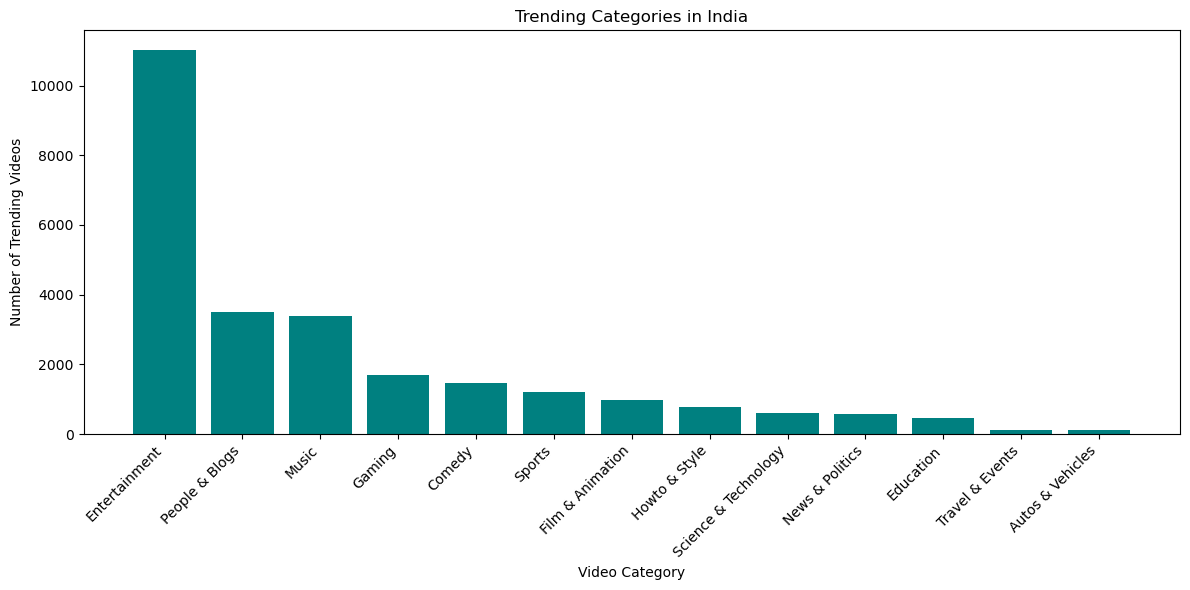

In [91]:
#plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df_cat_trends_pd["video_category_id"], df_cat_trends_pd["count"], color="teal")
plt.xticks(rotation=45, ha='right')
plt.title(f"Trending Categories in {country}")
plt.xlabel("Video Category")
plt.ylabel("Number of Trending Videos")
plt.tight_layout()
plt.show() 

In [93]:
#Choosing Country
country = "United States"

# Count how many times each category appeared in that country
df_cat_trends = df_engineered.filter(col("video_trending_country") == country) \
    .groupBy("video_category_id") \
    .count() \
    .orderBy("count", ascending=False) 

In [95]:
# converting to pandas for plotting
df_cat_trends_pd = df_cat_trends.toPandas() 

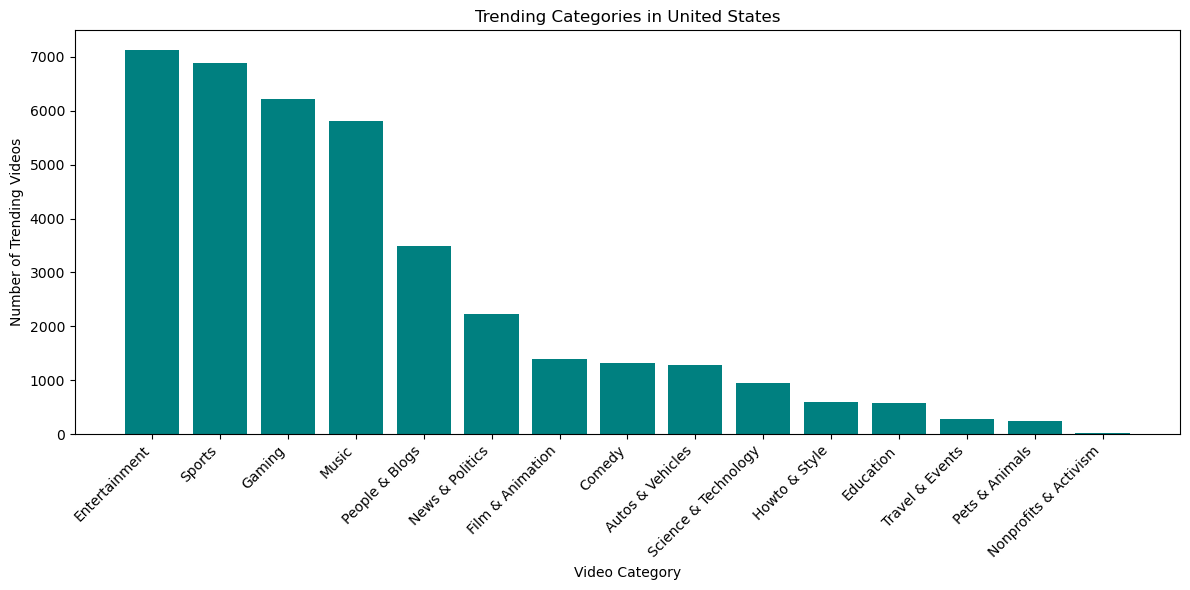

In [97]:
#ploting
plt.figure(figsize=(12, 6))
plt.bar(df_cat_trends_pd["video_category_id"], df_cat_trends_pd["count"], color="teal")
plt.xticks(rotation=45, ha='right')
plt.title(f"Trending Categories in {country}")
plt.xlabel("Video Category")
plt.ylabel("Number of Trending Videos")
plt.tight_layout()
plt.show() 

In [99]:
#Choosing Country
country = "Pakistan"

# Count how many times each category appeared in that country
df_cat_trends = df_engineered.filter(col("video_trending_country") == country) \
    .groupBy("video_category_id") \
    .count() \
    .orderBy("count", ascending=False) 

In [101]:
# converting to pandas for plotting
df_cat_trends_pd = df_cat_trends.toPandas() 

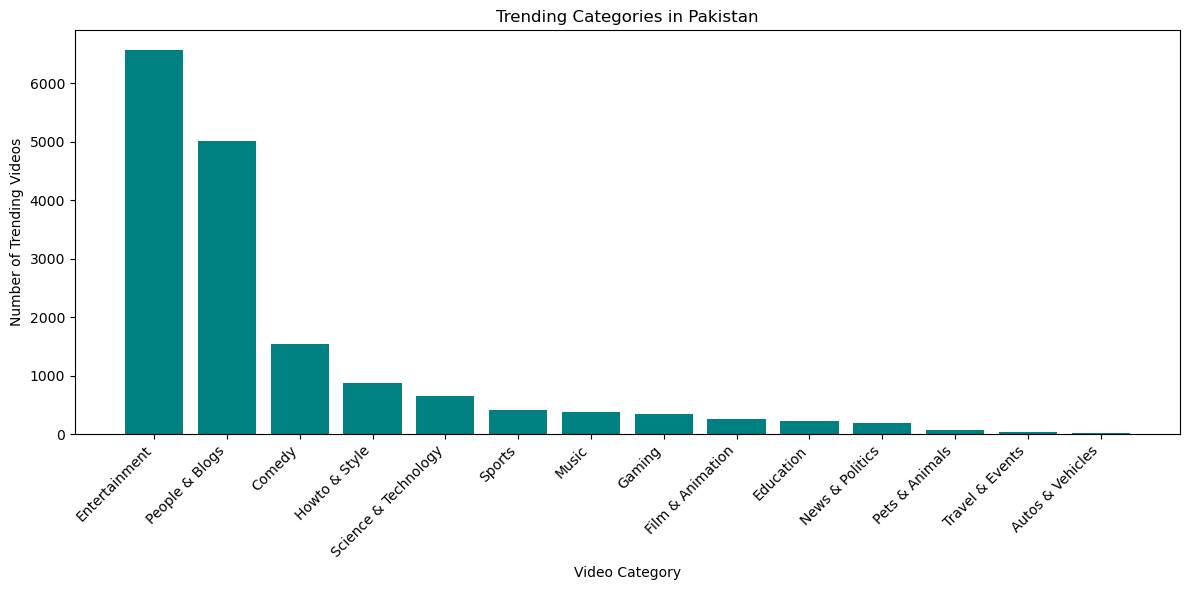

In [103]:
#plottting

plt.figure(figsize=(12, 6))
plt.bar(df_cat_trends_pd["video_category_id"], df_cat_trends_pd["count"], color="teal")
plt.xticks(rotation=45, ha='right')
plt.title(f"Trending Categories in {country}")
plt.xlabel("Video Category")
plt.ylabel("Number of Trending Videos")
plt.tight_layout()
plt.show() 

In [105]:
#Choosing Country
country = "Zimbabwe"

# Count how many times each category appeared in that country
df_cat_trends = df_engineered.filter(col("video_trending_country") == country) \
    .groupBy("video_category_id") \
    .count() \
    .orderBy("count", ascending=False) 

In [107]:
# converting to pandas for plotting
df_cat_trends_pd = df_cat_trends.toPandas() 

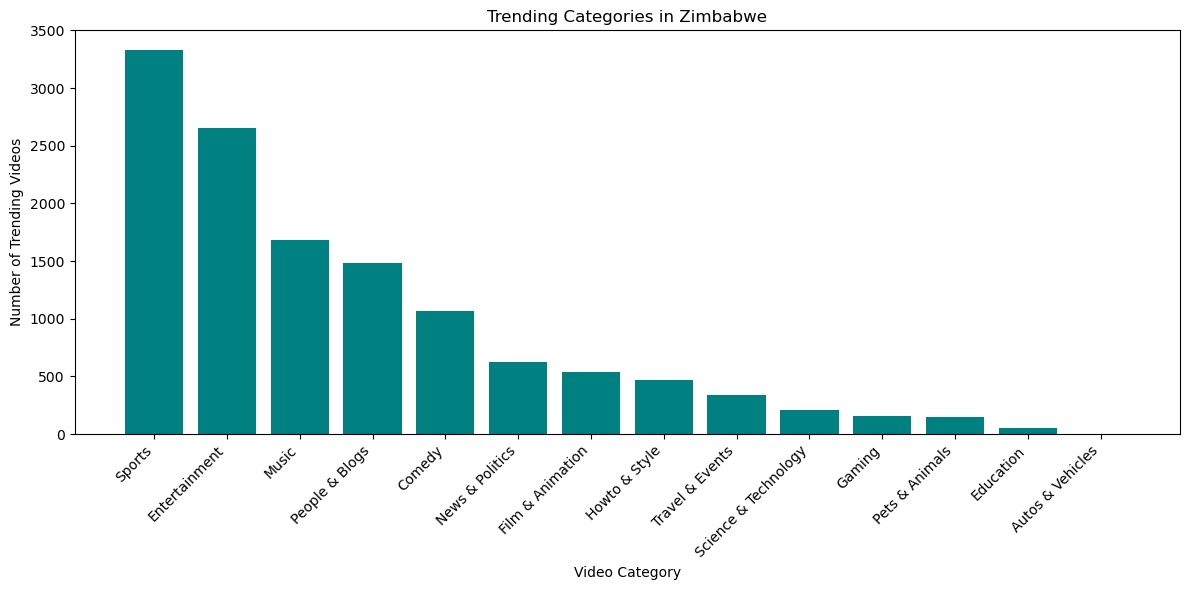

In [109]:
#plotting

plt.figure(figsize=(12, 6))
plt.bar(df_cat_trends_pd["video_category_id"], df_cat_trends_pd["count"], color="teal")
plt.xticks(rotation=45, ha='right')
plt.title(f"Trending Categories in {country}")
plt.xlabel("Video Category")
plt.ylabel("Number of Trending Videos")
plt.tight_layout()
plt.show() 

In [111]:
from pyspark.sql.functions import avg

df_engineered.groupBy("tags_count") \
    .agg(avg("video_view_count").alias("avg_views")) \
    .orderBy("tags_count") \
    .show() 

+----------+--------------------+
|tags_count|           avg_views|
+----------+--------------------+
|        -1|  2.14820818115084E7|
|         1|   4606068.872811329|
|         2|   6900768.137985459|
|         3|   7410824.975375387|
|         4|   8523792.768572023|
|         5| 2.243120802057561E7|
|         6|   6284221.335127737|
|         7|   7927866.023907346|
|         8|   7960890.748918739|
|         9|   5885537.793650222|
|        10| 1.812998664004382E7|
|        11|   8040914.489595453|
|        12|   5005895.604348124|
|        13|   5202763.553940761|
|        14|   9491927.930367697|
|        15|   5804991.929097094|
|        16|  3.38308844794314E7|
|        17|   9200477.891068427|
|        18|    8876455.71858806|
|        19|1.2227174138813958E7|
+----------+--------------------+
only showing top 20 rows



In [113]:
from pyspark.sql.functions import when

df_engineered = df_engineered.withColumn(
    "tags_bucket",
    when((df_engineered["tags_count"] <= 5), "0-5")
    .when((df_engineered["tags_count"] <= 10), "6-10")
    .when((df_engineered["tags_count"] <= 15), "11-15")
    .when((df_engineered["tags_count"] <= 20), "16-20")
    .otherwise("21+")
) 

In [115]:
from pyspark.sql.functions import when

df_engineered = df_engineered.withColumn(
    "tags_bucket",
    when((df_engineered["tags_count"] <= 5), "0-5")
    .when((df_engineered["tags_count"] <= 10), "6-10")
    .when((df_engineered["tags_count"] <= 15), "11-15")
    .when((df_engineered["tags_count"] <= 20), "16-20")
    .otherwise("21+")
) 

In [117]:
from pyspark.sql.functions import avg

views_by_bucket = df_engineered.groupBy("tags_bucket") \
    .agg(avg("video_view_count").alias("avg_views")) \
    .orderBy("tags_bucket")

views_by_bucket.show() 

+-----------+--------------------+
|tags_bucket|           avg_views|
+-----------+--------------------+
|        0-5|1.9261517238804907E7|
|      11-15|    6769222.50084911|
|      16-20|1.5395434164373076E7|
|        21+|1.1151147700048301E7|
|       6-10|   9370309.287102193|
+-----------+--------------------+



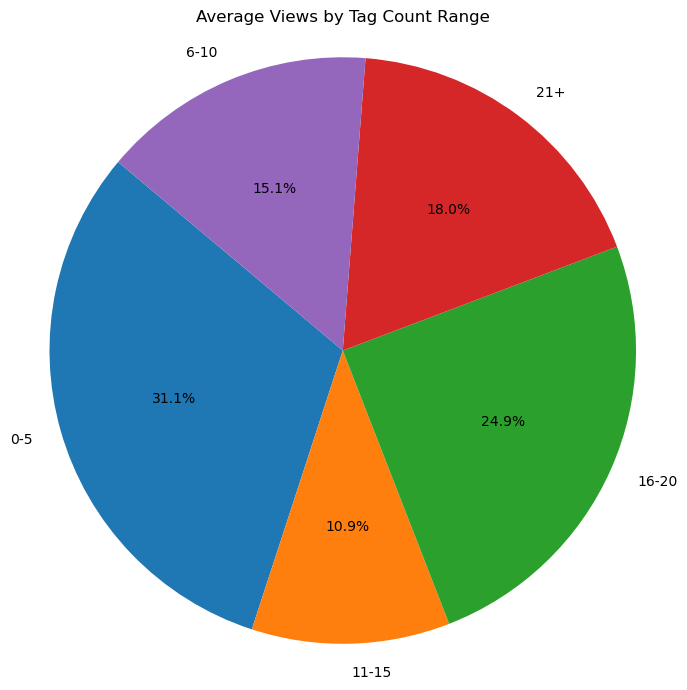

In [119]:
pdf = views_by_bucket.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.pie(pdf["avg_views"], labels=pdf["tags_bucket"], autopct='%1.1f%%', startangle=140)
plt.title("Average Views by Tag Count Range")
plt.axis("equal")
plt.tight_layout()
plt.show() 

# KEY INSIGHTS

1. Category performance :
   Categories like Entertainment, pets & Animals, Howto & style have the highest engagement.
2. Publish time does matter :
   Videos that are posted at 12 AM, 3 AM and 10 PM have the highest views. This means it does impact a video to trend.
3. Country level trends :
   Each country has diffrent categories that trend with average highest views. But majority of the counties have Entertainment,people and blogs.
4. Tags have influence but not largely
5. Most of the videos have highest views but with less comments and likes which indicates that users do not interact, watch time matters.
6. Most videos that were posted on Friday and Saturday had the highest views.

# Recommendations to content creators

1. Post at optimal times and day of the week.
2. Focus on what category trends in a country.
3. Use only few tags and with high video quality.
4. Use smaller title lengths for higher viwes.